In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from FileReader import load_mnist
from util import draw_barh

In [2]:
# train_set = load_mnist('train')
# train_imgs = torch.from_numpy(train_set['images']).type(torch.float)
# train_imgs = train_imgs.unsqueeze(dim=1)
# train_labels = torch.from_numpy(train_set['labels']).type(torch.long)
# print(train_imgs.shape)
# print(train_labels.shape)

In [3]:
# train_imgs_num = train_imgs.shape[0]
# BATCH_SIZE = int(train_imgs_num * 0.05)


In [4]:
# dataset = Data.TensorDataset(train_imgs, train_labels)
# loader = Data.DataLoader(
#     dataset=dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
# )


In [2]:
class LeNet5(nn.Module):
    
    def __init__(self, input_size):
        super(LeNet5, self).__init__()
        channel, height, width = input_size
        self.conv_1 = nn.Conv2d(in_channels=channel, out_channels=6, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.maxpooling_1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv_2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=(1,1))
        self.maxpooling_2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv_3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5), stride=(1,1))
        self.FC_4 = nn.Linear(in_features=120, out_features=84)
        self.ReLU_4 = nn.ReLU(inplace=False)
        self.FC_5 = nn.Linear(in_features=84, out_features=10)
    
    def forward(self, x):
        with torch.no_grad():
            self.num = x.shape[0]
        output_conv_1 = self.conv_1(x)
        output_pool_1 = self.maxpooling_1(output_conv_1)
        output_conv_2 = self.conv_2(output_pool_1)
        output_pool_2 = self.maxpooling_2(output_conv_2)
        output_conv_3 = self.conv_3(output_pool_2).view(self.num,-1)
        output_fc_4 = self.FC_4(output_conv_3)
        output_relu_4 = self.ReLU_4(output_fc_4)
        output_fc_5 = self.FC_5(output_relu_4)
        return output_fc_5

model = LeNet5((1,28,28))
print(model)

LeNet5(
  (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpooling_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpooling_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (FC_4): Linear(in_features=120, out_features=84, bias=True)
  (ReLU_4): ReLU()
  (FC_5): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# loss_function = nn.CrossEntropyLoss()

In [7]:
# for epoch in xrange(2):
#     for step, (batch_imgs, batch_labels) in enumerate(loader):
#         y_pred = model(batch_imgs)
#         loss = loss_function(y_pred, batch_labels)
        
#         #更新参数
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         print ('epoch {} | batch {} loss: {}'.format(epoch+1, step+1, loss.data.item()))

In [3]:
model.load_state_dict(torch.load('mnist_LeNet5_model.pkl'))

In [4]:
test_set = load_mnist('t10k')
origin = test_set['images']
test_imgs = torch.from_numpy(test_set['images']).type(torch.float)
test_imgs_feed = test_imgs.unsqueeze(dim=1)
test_labels = torch.from_numpy(test_set['labels']).type(torch.long)


In [10]:
# top_k = 1
# acc = 0
# y_pred = model(test_imgs)
# ss, indices = torch.sort(y_pred, dim=1, descending=True)
# results = indices[:,0:top_k]
# for idx, label in enumerate(test_labels):
#     if label in results[idx]:
#         acc += 1
# print ('accuracy: {}'.format(float(acc)/test_labels.shape[0]))

In [11]:
# torch.save(model.state_dict(), 'mnist_LeNet5_model.pkl')

In [12]:
# test_expl = test_imgs[24]
# test_expl = test_expl.unsqueeze(0)
# y_pred = model(test_expl)

In [13]:
# labels = torch.arange(0,10,1).numpy()
# with torch.no_grad():
#     plt.figure()
#     test_expl = test_expl.squeeze(0)
#     plt.imshow(test_expl, cmap='Greys')
#     plt.show()
#     y_pred.squeeze_(0)
#     draw_barh(tensor=y_pred, labels=labels, title='result')

In [5]:
# run knn to see details of the feature vector
opt_1 = model.conv_1(test_imgs_feed)
opt_2 = model.maxpooling_1(opt_1)
opt_3 = model.conv_2(opt_2)
opt_4 = model.maxpooling_2(opt_3)
opt_5 = model.conv_3(opt_4)

In [6]:
with torch.no_grad():
    feature = opt_5.view(10000, -1)

In [7]:
standard_idx = [3, 2, 1, 18, 4, 15, 11, 0, 84, 7]

In [8]:
def knn(k, target_tensor, data_tensor):
    height, width = data_tensor.shape
    with torch.no_grad():
        probe = target_tensor.clone().view(1, width)
        data = data_tensor.clone()
        dist = torch.norm(input=(data-probe), dim=1)
        ss, indices = torch.sort(dist)
        result = indices[1:k+1]
        return result

In [48]:
# mask = 0
# k_nearest = 5
# while mask < 10:
#     plt.figure()
#     plt.subplot(1, k_nearest+1, 1)
#     plt.imshow(test_imgs[standard_idx[mask]], cmap='Greys')
#     result = knn(k_nearest, feature[standard_idx[mask]], feature)
#     for i in xrange(k_nearest):
#         plt.subplot(1, k_nearest+1, i+2)
#         plt.imshow(test_imgs[result[i]], cmap='Greys')
#     plt.show()
#     mask += 1
#     print(result)

In [14]:
# run pca

def pca(k, tensor):
    data = tensor.clone()
    #zero-center procedure
    data -= torch.mean(data, dim=0).view(1, -1)
    convariance_matrix = data.t().mm(data)
    eigenvalue, eigenvector = torch.eig(convariance_matrix, eigenvectors=True)
    result = data.mm(eigenvector[0:k].t())
    return result

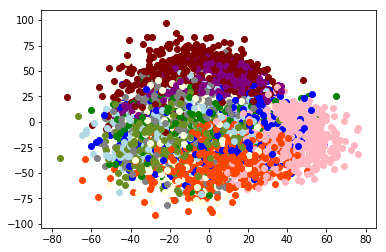

In [15]:
dim_reduce_feature = pca(2, feature)
plt.figure()
color = ['#FFB6C1', '#800080', '#0000FF', '#008000', '#6B8E23', '#FFFFE0', '#FF4500', '#800000', '#808080', '#ADD8E6']
for i in xrange(dim_reduce_feature.shape[0]):
    plt.scatter(dim_reduce_feature[i,0].data.numpy(), dim_reduce_feature[i,1].data.numpy(), color=color[test_labels[i]])
plt.show()

In [71]:
t_sne = TSNE(n_components=2, init='pca')
tsne_feature = t_sne.fit_transform(feature.data.numpy())


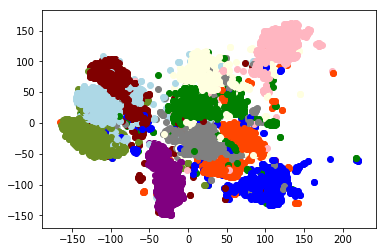

In [76]:
plt.figure()
for i in xrange(tsne_feature.shape[0]):
    plt.scatter(tsne_feature[i,0], tsne_feature[i,1], color=color[test_labels[i]])
plt.show()